In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import pickle
import random

import torch
import torch.nn.functional as F

In [2]:
with uproot.open("../pythia/output/dataset_ttbar_mu60_NumEvents10000_MinJetpT25.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()
    jet_m = f["jet_m"].array()
    trk_pt = f["trk_jet_pT"].array()
    trk_eta = f["trk_jet_eta"].array()
    trk_phi = f["trk_jet_phi"].array()
    trk_q = f["trk_jet_q"].array()
    trk_d0 = f["trk_jet_d0"].array()
    trk_z0 = f["trk_jet_z0"].array()
    trk_label = f["trk_jet_label"].array()
    jet_trk_IDX = f["jet_track_index"].array()
    jet_pufr_truth = f["jet_pufr_truth"].array()

In [3]:
%%time
jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_corrJVF,jet_RpT,jet_m,jet_pufr_truth]
jet_feat_list = [x[:,:,np.newaxis] for x in jet_feat_list]
jet_feats = ak.concatenate(jet_feat_list, axis=2)

print("Num Events: ", len(jet_feats))
print("Num Jets in first event: ", len(jet_feats[0]))
print("Num Jet Features: ", len(jet_feats[0][0]))

Num Events:  10000
Num Jets in first event:  105
Num Jet Features:  7
CPU times: user 51.6 ms, sys: 1.58 ms, total: 53.2 ms
Wall time: 52.5 ms


In [4]:
%%time
trk_feat_list = [trk_pt,trk_eta,trk_phi,trk_q,trk_d0,trk_z0,trk_label]
trk_feat_list = [x[:,:,:,np.newaxis] for x in trk_feat_list]
trk_feats = ak.concatenate(trk_feat_list, axis=3)

print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Num Events:  10000
Num Jets in first event:  105
Num Tracks in first event first jet:  115
Num Tracks features:  7
CPU times: user 4 s, sys: 1.88 s, total: 5.88 s
Wall time: 5.88 s


In [5]:
jet_mask = abs(jet_feats[:,:,1])<4
selected_jets = jet_feats[jet_mask]
selected_tracks = trk_feats[jet_mask]

trk_q_cut = selected_tracks[:,:,:,3]!=0          # Skip neutral particles
trk_eta_cut = abs(selected_tracks[:,:,:,1])<4    # Skip forward region
trk_pt_cut = selected_tracks[:,:,:,0]>0.4        # 400MeV Cut

mask = trk_q_cut & trk_eta_cut & trk_pt_cut

selected_tracks = selected_tracks[mask]

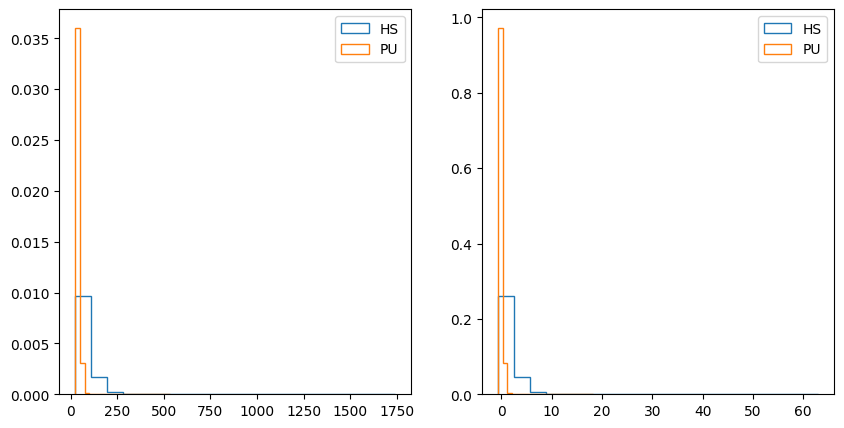

Mean Before:  43.10744707047052 		 Mean After:  -0.00019574088125692078
STD Before:  26.98638021674177 		 STD After:  1.0004233167559595


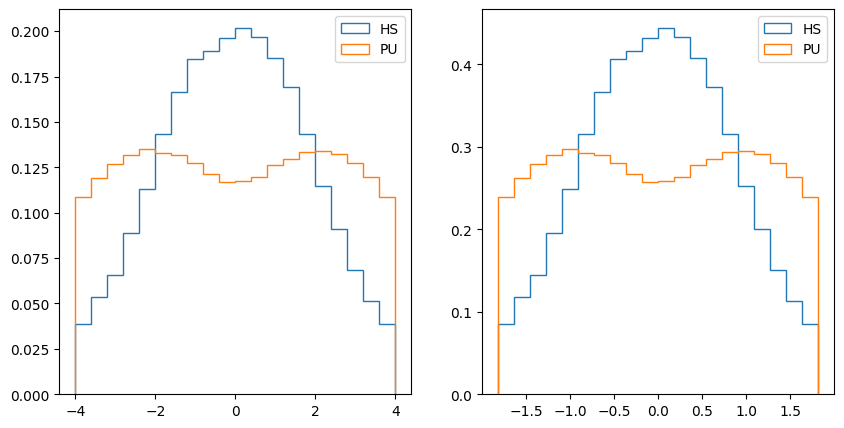

Mean Before:  0.0010211801947400156 		 Mean After:  7.617865444454714e-09
STD Before:  2.201341325100819 		 STD After:  1.0000882632503687


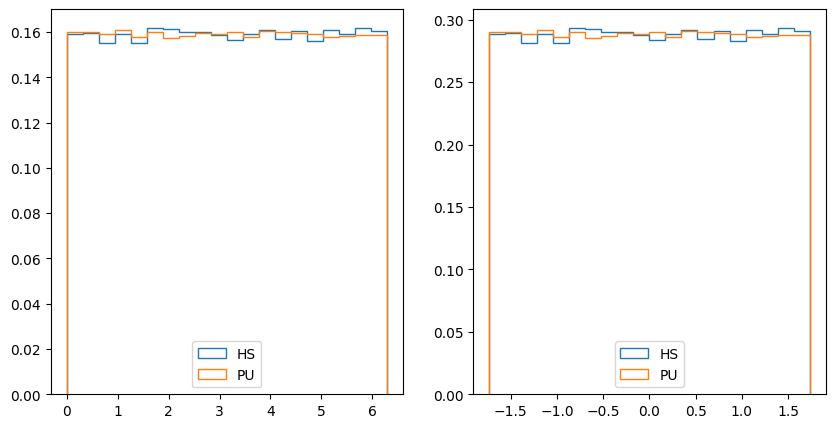

Mean Before:  3.139858293423656 		 Mean After:  1.787610134332017e-05
STD Before:  1.8135988545013726 		 STD After:  1.0002614730462935


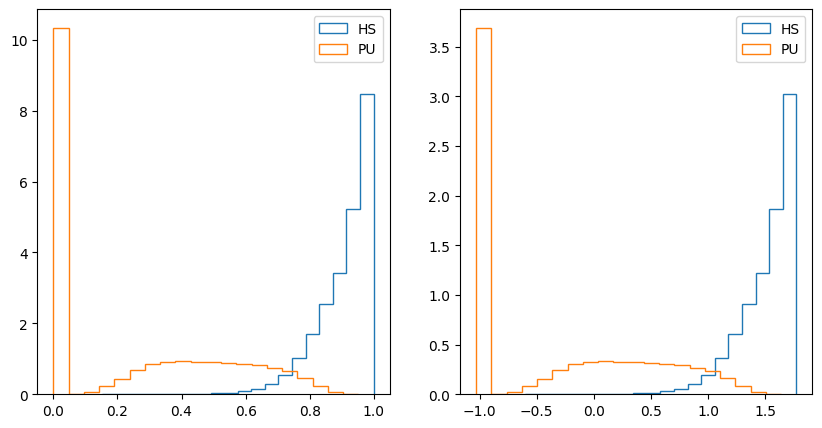

Mean Before:  0.3677340987364588 		 Mean After:  1.3781199309242491e-05
STD Before:  0.3568709063046282 		 STD After:  0.9999874933381773


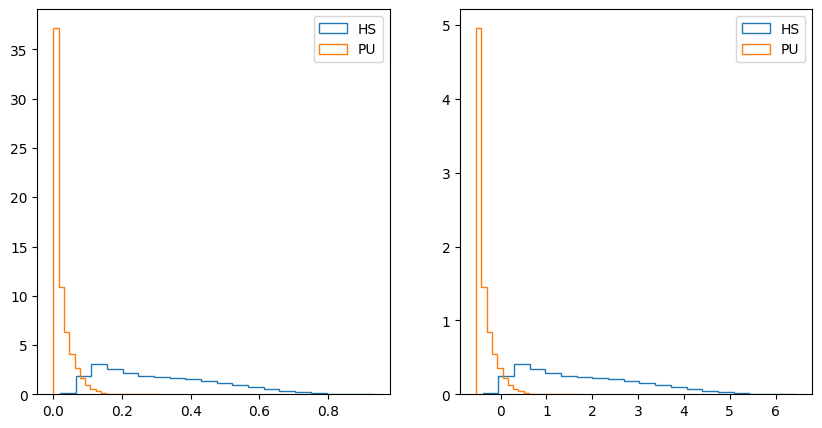

Mean Before:  0.07154290007672039 		 Mean After:  2.5705573888680313e-06
STD Before:  0.13335492297326082 		 STD After:  1.0002604386344192


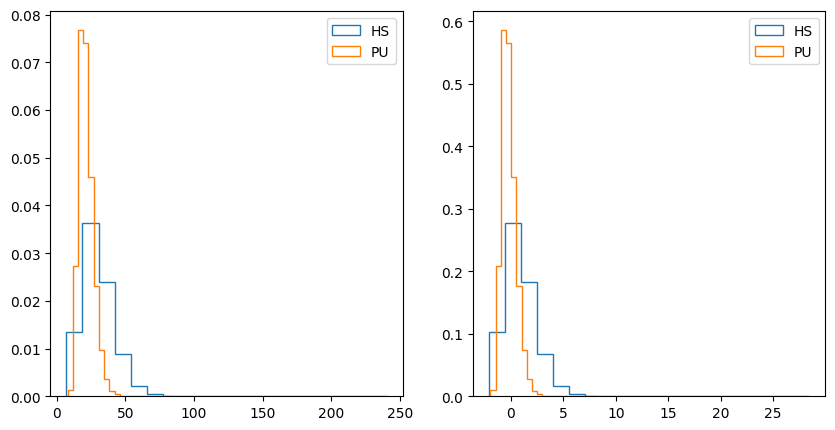

Mean Before:  22.936065785219768 		 Mean After:  -2.5751396163243298e-05
STD Before:  7.637151944795205 		 STD After:  1.000012578986871


In [6]:
num_jet_feats = len(selected_jets[0][0])-1

sig = selected_jets[:,:,-1]<0.7
bkg = ~sig

# Normalize and Plot Jet Features
norm_list = []
for i in range(num_jet_feats):
    feat = selected_jets[:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax1.legend()
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax2.legend()
    plt.show()
    print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))
# Append Labels
norm_list.append(selected_jets[:,:,-1])

Norm_list = [x[:,:,np.newaxis] for x in norm_list]
selected_jets = ak.concatenate(Norm_list, axis=2)

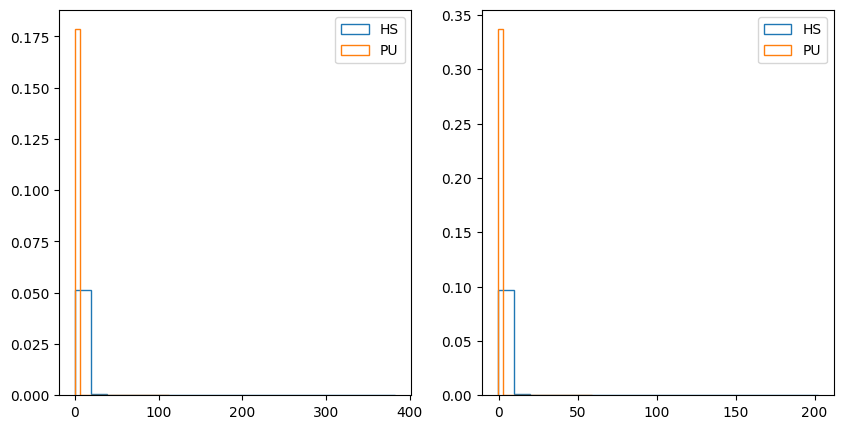

Mean Before:  1.09811269409627 		 Mean After:  8.688739883350743e-18
STD Before:  1.8869364623020979 		 STD After:  0.999999999999714


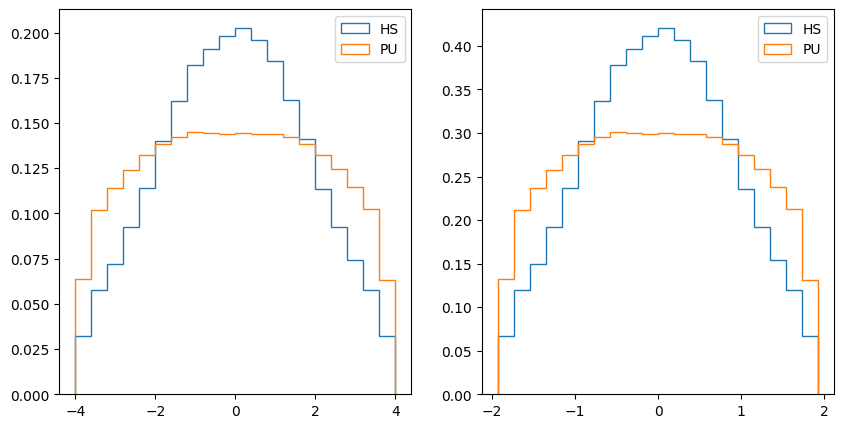

Mean Before:  0.001139438010972194 		 Mean After:  7.535136765552262e-17
STD Before:  2.0764914291404146 		 STD After:  0.9999999999995357


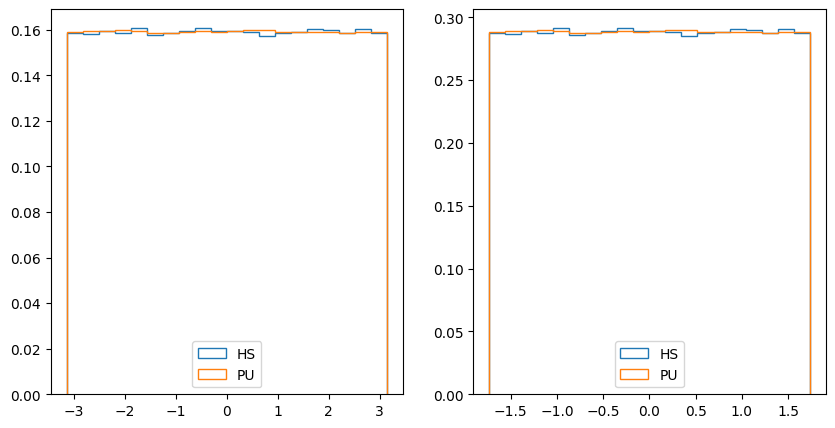

Mean Before:  -0.0007743238107307571 		 Mean After:  4.6042391017029045e-18
STD Before:  1.8134899262631 		 STD After:  0.9999999999995689


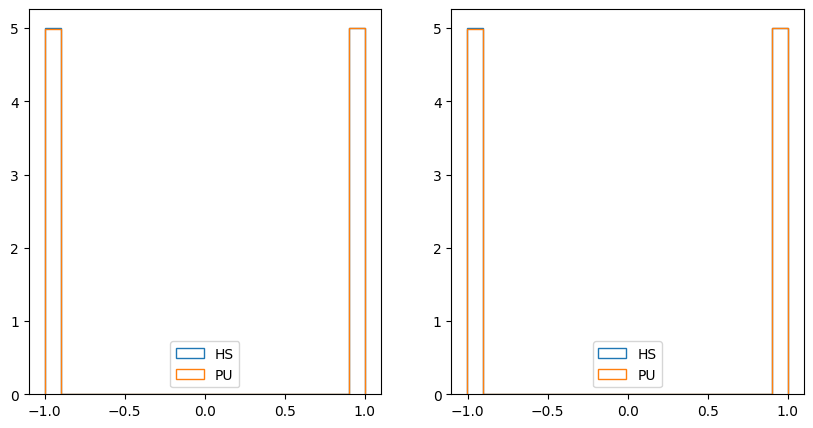

Mean Before:  0.0012392434558865534 		 Mean After:  9.030888972892868e-15
STD Before:  0.9999992321375337 		 STD After:  1.000000000016739


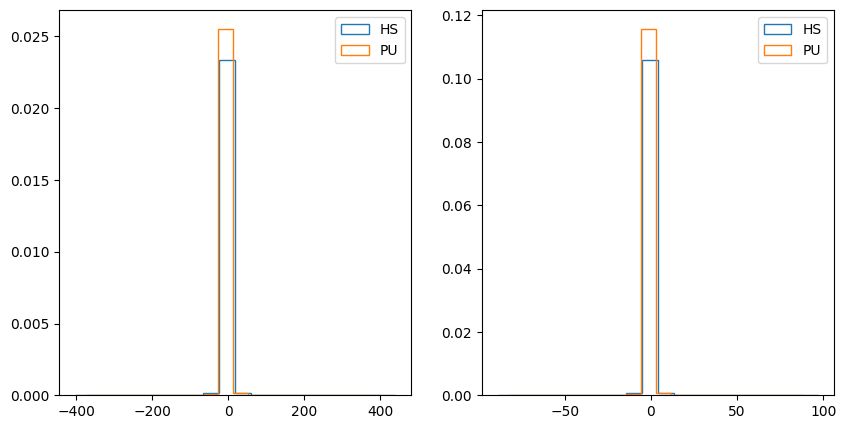

Mean Before:  -0.0005067009008489634 		 Mean After:  2.857556194507491e-17
STD Before:  4.535076278326754 		 STD After:  0.999999999999959


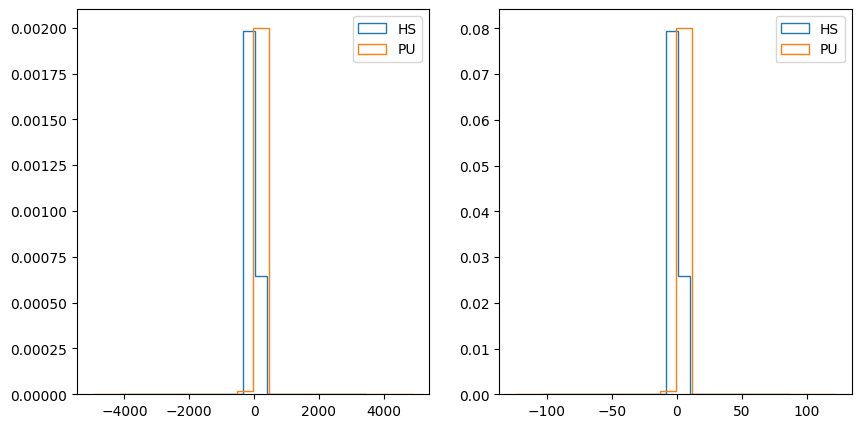

Mean Before:  -0.02870841532754108 		 Mean After:  4.2613748099718876e-19
STD Before:  40.05265572594446 		 STD After:  1.0000000000000506


In [7]:
num_trk_feats = len(selected_tracks[0][0][0])-1

sig = selected_tracks[:,:,:,-1]==-1
bkg = ~sig

norm_list = []
for i in range(num_trk_feats):
    feat = selected_tracks[:,:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax1.legend()
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax2.legend()
    plt.show()
    print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))
norm_list.append(selected_tracks[:,:,:,-1])
    
Norm_list = [x[:,:,:,np.newaxis] for x in norm_list]
selected_tracks = ak.concatenate(Norm_list, axis=3)

In [8]:
all_tracks = ak.flatten(selected_tracks, axis=2)

print("Jet Shape:\t", selected_jets.type)
print("Trk_Jet  Shape:\t", selected_tracks.type)
print("Trk_All Shape:\t", all_tracks.type)

Jet Shape:	 10000 * var * 7 * float64
Trk_Jet  Shape:	 10000 * var * var * 7 * float64
Trk_All Shape:	 10000 * var * 7 * float64


In [9]:
def get_random_selection(pairs, n):
    rng = np.random.random_sample(len(pairs))
    sorted_idx = np.flip(np.argsort(rng))
    rng_pairs = pairs[sorted_idx]
    return rng_pairs[0:n]

def get_similar_HS_sample(jet_labels,threshold=0.5):
    HS_idx = np.where(jet_labels<threshold)[0]
    comb = ak.combinations(HS_idx, 2, axis=0)
    return comb.to_list()

def get_similar_PU_sample(jet_labels,n,threshold=0.5):
    PU_idx = np.where(jet_labels>threshold)[0]
    comb = ak.combinations(PU_idx, 2, axis=0)
    if len(comb)<n:
        return comb.to_list()
    else:
        comb = get_random_selection(comb,n)
    return comb.to_list()

def get_dissimilar_sample(jet_labels,n,threshold=0.5):
    n = int(2*n) # Parameter to adjust balance of dataset
    HS_idx = np.where(jet_labels<threshold)[0]
    PU_idx = np.where(jet_labels>threshold)[0]
    comb = ak.cartesian([HS_idx,PU_idx], axis=0)
    if len(comb)<n:
        return comb.to_list()
    else:
        comb = get_random_selection(comb,n)
    return comb.to_list()

In [10]:
class ContrastiveDataset:
    def __init__(self):
        self.Jet1 = self.Jet()
        self.Jet2 = self.Jet()
        self.label = []
        
    def __len__(self):
        return len(self.label)
        
    class Jet:
        def __init__(self):
            self.jet_feats = []
            self.trk_feats = []
            self.jet_label = []
            
    def add_pair(self, jet1_feats, jet2_feats, label):
        jet1, trk1, label1 = jet1_feats
        jet2, trk2, label2 = jet2_feats
        
        self.Jet1.jet_feats = ak.concatenate([self.Jet1.jet_feats,jet1[np.newaxis]],axis=0)
        self.Jet1.trk_feats = ak.concatenate([self.Jet1.trk_feats,trk1[np.newaxis]],axis=0)
        self.Jet1.jet_label = ak.concatenate([self.Jet1.jet_label,label1],axis=0)
                                               
        self.Jet2.jet_feats = ak.concatenate([self.Jet2.jet_feats,jet2[np.newaxis]],axis=0)
        self.Jet2.trk_feats = ak.concatenate([self.Jet2.trk_feats,trk2[np.newaxis]],axis=0)
        self.Jet2.jet_label = ak.concatenate([self.Jet2.jet_label,label2],axis=0)
                                               
        self.label = ak.concatenate([self.label,label])
        
    def shuffle_dataset(self):
        p = np.random.permutation(len(self.label))
        
        print(p)
        
        self.Jet1.jet_feats = self.Jet1.jet_feats[p]
        self.Jet2.jet_feats = self.Jet2.jet_feats[p]
        self.Jet1.trk_feats = self.Jet1.trk_feats[p]
        self.Jet2.trk_feats = self.Jet2.trk_feats[p]
        self.Jet1.jet_label = self.Jet1.jet_label[p]
        self.Jet2.jet_label = self.Jet2.jet_label[p]
        self.label = self.label[p]
        self.label = self.label[p]

In [11]:
%%time
num_events = len(jet_pt)
num_events = 100

dataset = ContrastiveDataset()

for event in range(num_events):
    HS_comb = get_similar_HS_sample(selected_jets[event,:,-1])
    PU_comb = get_similar_PU_sample(selected_jets[event,:,-1], len(HS_comb))
    Dis_comb = get_dissimilar_sample(selected_jets[event,:,-1], len(HS_comb))
        
    for pair in HS_comb:
        jet1_feats = selected_jets[event,pair[0],0:-1]
        jet1_trk_feats = selected_tracks[event,pair[0],:,0:-1]
        jet1_label = selected_jets[event,pair[0],-1]
        
        jet1 = [jet1_feats,jet1_trk_feats,jet1_label]
        
        jet2_feats = selected_jets[event,pair[1],0:-1]
        jet2_trk_feats = selected_tracks[event,pair[1],:,0:-1]
        jet2_label = selected_jets[event,pair[1],-1]
        
        jet2 = [jet2_feats,jet2_trk_feats,jet2_label]
        
        dataset.add_pair(jet1,jet2,1)
        
    for pair in PU_comb:
        jet1_feats = selected_jets[event,pair[0],0:-1]
        jet1_trk_feats = selected_tracks[event,pair[0],:,0:-1]
        jet1_label = selected_jets[event,pair[0],-1]
        
        jet1 = [jet1_feats,jet1_trk_feats,jet1_label]
        
        jet2_feats = selected_jets[event,pair[1],0:-1]
        jet2_trk_feats = selected_tracks[event,pair[1],:,0:-1]
        jet2_label = selected_jets[event,pair[1],-1]
        
        jet2 = [jet2_feats,jet2_trk_feats,jet2_label]
        
        dataset.add_pair(jet1,jet2,1)
        
    for pair in Dis_comb:
        jet1_feats = selected_jets[event,pair[0],0:-1]
        jet1_trk_feats = selected_tracks[event,pair[0],:,0:-1]
        jet1_label = selected_jets[event,pair[0],-1]
        
        jet1 = [jet1_feats,jet1_trk_feats,jet1_label]
        
        jet2_feats = selected_jets[event,pair[1],0:-1]
        jet2_trk_feats = selected_tracks[event,pair[1],:,0:-1]
        jet2_label = selected_jets[event,pair[1],-1]
        
        jet2 = [jet2_feats,jet2_trk_feats,jet2_label]
        
        dataset.add_pair(jet1,jet2,0)

CPU times: user 38.1 s, sys: 34.8 ms, total: 38.1 s
Wall time: 38.1 s


In [12]:
#dataset.shuffle_dataset()

In [13]:
pickle.dump(dataset, open("ContrastiveDataset.pkl", "wb"))

In [14]:
data = pickle.load( open( "ContrastiveDataset.pkl", "rb" ) )

In [15]:
print(data.Jet1.jet_label)
print(type(data.Jet1.jet_label))

[0.0178, 0.0178, 0.0178, 0.0178, 0.0178, ..., 0.0111, 0.0111, 0.16, 0.00423]
<class 'awkward.highlevel.Array'>


In [16]:
raise Exception("Stop")

Exception: Stop

In [ ]:
# Generate List of torch tensors on event by event basis
# Pad number of tracks per jet 

num_events = len(selected_jets)

Event_Data = []
Event_Labels = []

for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    jets = torch.Tensor(selected_jets[event,:,:])
    
    num_trks = ak.num(selected_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)

    trk_list = []
    num_jets = len(selected_jets[event])
    for jet in range(num_jets):
        tracks = torch.Tensor(selected_tracks[event][jet,:])
        pad = (0,0,0,max_num_trks-len(tracks))
        tracks = F.pad(tracks,pad)
        trk_list.append(torch.unsqueeze(tracks,dim=0))
    tracks = torch.cat(trk_list,dim=0)
    
    # Append all data but don't include label 0:-1!
    flat_tracks = torch.Tensor(all_tracks[event][:,0:-1])
    Event_Data.append((jets[:,0:-1],tracks[:,:,0:-1],flat_tracks))
    #Event_Labels.append((jets[:,-1].reshape(-1,1),tracks[:,:,-1].reshape(-1,1)))
    Event_Labels.append(jets[:,-1].reshape(-1,1))

print("Processing: ", num_events, " / ", num_events)